In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn import model_selection, tree, neighbors, metrics, ensemble
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df_train= pd.read_csv('LFTS_train/train.csv')
df_test= pd.read_csv('LFTS_test.csv')

In [3]:
#20 most correlated features
train=df_train[['ltv','disbursed_amount','PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE','State_ID','VoterID_flag',
              'NO.OF_INQUIRIES','Aadhar_flag','PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','PRI.NO.OF.ACCTS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
              'NEW.ACCTS.IN.LAST.SIX.MONTHS','Employment.Type','PRI.CURRENT.BALANCE','Employee_code_ID','asset_cost','PRI.SANCTIONED.AMOUNT',
              'PRI.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','loan_default']]
test=df_test[['ltv','disbursed_amount','PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE','State_ID','VoterID_flag',
              'NO.OF_INQUIRIES','Aadhar_flag','PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','PRI.NO.OF.ACCTS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
              'NEW.ACCTS.IN.LAST.SIX.MONTHS','Employment.Type','PRI.CURRENT.BALANCE','Employee_code_ID','asset_cost','PRI.SANCTIONED.AMOUNT',
              'PRI.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT']]

In [4]:
train=train.drop(['PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS','Aadhar_flag','NEW.ACCTS.IN.LAST.SIX.MONTHS','asset_cost','PRI.DISBURSED.AMOUNT'], axis=1)
test=test.drop(['PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS','Aadhar_flag','NEW.ACCTS.IN.LAST.SIX.MONTHS','asset_cost','PRI.DISBURSED.AMOUNT'], axis=1)

In [5]:
print(train.shape)
print(test.shape)

(233154, 15)
(112392, 14)


In [6]:
# if u just use dropna then u are loosing aroound 10k data points. So lets instead fill these up by first knowing how many values are null in each column
# train.dropna(inplace=True)
pd.isnull(train).sum()

ltv                                       0
disbursed_amount                          0
PERFORM_CNS.SCORE.DESCRIPTION             0
State_ID                                  0
VoterID_flag                              0
NO.OF_INQUIRIES                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS                         0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS       0
Employment.Type                        7661
PRI.CURRENT.BALANCE                       0
Employee_code_ID                          0
PRI.SANCTIONED.AMOUNT                     0
PRIMARY.INSTAL.AMT                        0
loan_default                              0
dtype: int64

In [7]:
train['Employment.Type'].fillna(train['Employment.Type'].dropna().max(), inplace=True)
test['Employment.Type'].fillna(test['Employment.Type'].dropna().max(), inplace=True)

In [8]:
le=LabelEncoder()
col=['PERFORM_CNS.SCORE.DESCRIPTION', 'Employment.Type', 'Employee_code_ID']
for c in col:
    train[c]=le.fit_transform(train[c])
    test[c]=le.fit_transform(test[c])

0: 182543
1: 50611


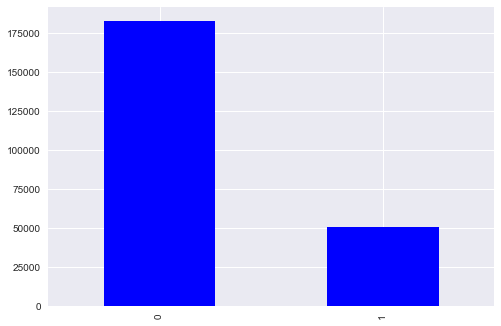

In [9]:
target_count= train['loan_default'].value_counts()
target_count.plot(kind='bar')
print('0:',target_count[0])
print('1:',target_count[1])
plt.show()

as u can see the class in imbalance, so to avoid this imbalance we can either reduce the no of samples of target 0(undersampling) or increase the samples of target 1(oversampling). undersampling will result in loss of data but oversampling will result in overfitting.

In [10]:
count_0, count_1=train['loan_default'].value_counts()
train_0=train[train['loan_default']==0]
train_1=train[train['loan_default']==1]

random under sampling

In [11]:
df_under=train_0.sample(count_1)
df_under=pd.concat([df_under, train_1], axis=0)
df_under['loan_default'].value_counts()

1    50611
0    50611
Name: loan_default, dtype: int64

random over sampling

In [12]:
df_over=train_1.sample(count_0, replace=True)
df_over=pd.concat([df_over,train_0], axis=0)
df_over['loan_default'].value_counts()

1    182543
0    182543
Name: loan_default, dtype: int64

In [13]:
df_over.shape

(365086, 15)

In [36]:
# apply scaler to the data
y_over=df_over['loan_default']
x_over=df_over.drop('loan_default',1)
y_under=df_under['loan_default']
x_under=df_under.drop('loan_default',1)

In [37]:
scaler=MinMaxScaler(feature_range=(0,1))
x_under_scale=pd.DataFrame(scaler.fit_transform(x_under))
x_over_scale=pd.DataFrame(scaler.fit_transform(x_over))
# x_over_smote_scale=pd.DataFrame(scaler.fit_transform(x_over_smote))
# test=pd.DataFrame(scaler.fit_transform(test))

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
train_x, test_x, train_y, test_y= model_selection.train_test_split(x_over_scale, y_over, test_size=0.33)

In [17]:
test_y.value_counts()

0    60358
1    60121
Name: loan_default, dtype: int64

In [18]:
rf1=ensemble.RandomForestClassifier(n_estimators=1500)
rf1.fit(train_x, train_y)
print('acc: ',rf1.score(test_x, test_y))
pred_rf1=rf1.predict(test_x)
print('auc: ',metrics.roc_auc_score(test_y, pred_rf1))
print(metrics.confusion_matrix(test_y, pred_rf1))

acc:  0.9005386830899991
auc:  0.9005899103397498
[[52786  7572]
 [ 4411 55710]]


In [28]:
rf=ensemble.RandomForestClassifier()
rf.fit(train_x, train_y)
print('acc: ',rf.score(test_x, test_y))
# pred_rf1=rf1.predict(test_x)
# print('auc: ',metrics.roc_auc_score(test_y, pred_rf1))
# print(metrics.confusion_matrix(test_y, pred_rf1))

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


acc:  0.8826185476307075


In [32]:
xgb=XGBClassifier()
xgb.fit(train_x, train_y)
print('acc: ',xgb.score(test_x, test_y))
pred_xgb= xgb.predict(test_x)
# print('auc: ',metrics.roc_auc_score(test_y, pred_xgb))
print(metrics.confusion_matrix(test_y, pred_xgb))

acc:  0.6051594053735506
auc:  0.6052737067835032
[[33026 27332]
 [20238 39883]]


In [38]:
train_x, test_x, train_y, test_y= model_selection.train_test_split(x_under_scale, y_under, test_size=0.33)

In [39]:
rf=ensemble.RandomForestClassifier()
rf.fit(train_x, train_y)
print('acc: ',rf.score(test_x, test_y))
pred_rf=rf.predict(test_x)
print('auc: ',metrics.roc_auc_score(test_y, pred_rf))
print(metrics.confusion_matrix(test_y, pred_rf))

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


acc:  0.5614597054245001
auc:  0.5618707940641663
[[10766  5856]
 [ 8793  7989]]


In [49]:
scaler=StandardScaler()
scaler.fit(x_under)
x_under_scale = scaler.transform(x_under)
test=scaler.transform(test)

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
train_x, test_x, train_y, test_y= model_selection.train_test_split(x_under_scale, y_under, test_size=0.33)

In [51]:
rf=ensemble.RandomForestClassifier()
rf.fit(train_x, train_y)
print('acc: ',rf.score(test_x, test_y))

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


acc:  0.5588851634534786


In [52]:
out=pd.concat([df_test['UniqueID'], pd.DataFrame(rf.predict(test),columns=['loan_default'])], axis=1)
out.head()

,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,0
4,708663,0


In [53]:
out.to_csv('loan_predict.csv', encoding='utf-8', index=False)